# Modeling

We decided to **split the noebooks** in order to be faster, since we don't need graphs anymore.

In [363]:
import pandas as pd

In [364]:
import seaborn as sb
import matplotlib.pyplot as plt


In [365]:
df = pd.read_parquet("https://github.com/maikuvit/Space-Capybaras-Final-Project/raw/main/train_clean.parquet")
df

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,GarageArea,GrLivArea,LotFrontage,MoSold,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,856,854,3,706,1,150,548,1710,65,2,...,False,False,False,False,False,False,False,False,False,False
1,1262,0,3,978,0,284,460,1262,80,5,...,False,False,False,False,False,False,False,False,False,True
2,920,866,3,486,1,434,608,1786,68,9,...,False,False,False,False,False,False,False,False,False,False
3,961,756,3,216,1,540,642,1717,60,2,...,False,False,False,False,False,False,False,False,False,False
4,1145,1053,4,655,1,490,836,2198,84,12,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,3,0,0,953,460,1647,62,8,...,False,False,False,False,False,False,False,False,False,False
1456,2073,0,3,790,1,589,500,2073,85,2,...,False,False,False,False,False,False,False,False,False,False
1457,1188,1152,4,275,0,877,252,2340,66,5,...,False,False,False,False,False,False,False,False,False,False
1458,1078,0,2,49,1,0,240,1078,68,4,...,False,False,False,False,False,False,False,False,False,False


# Modeling

In [387]:
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(df.drop(['SalePrice'], axis=1).values)
y = np.array(df['SalePrice'].values)


seed = 150
test_size = .3
val_size = .2

#Split train e test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)


### Resampling for high class label

In [389]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state=seed, sampling_strategy='minority')
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)


## Creating models

In [429]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score

In [431]:
# create a model for each sampling method
models = []
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('GB', GradientBoostingClassifier(random_state=seed)))
models.append(('AB', AdaBoostClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))


In [432]:
# fit each model using the training data from the oversampling 
# and evaluate its performance on the test data and save precision, accuracy, recall and f1-score

results = []
names = []

for name, model in models:
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    results.append([accuracy, precision, recall, f1score, confusion_matrix(y_test, y_pred)])
    names.append(name)



In [433]:
# create a dataframe with the results
df_results = pd.DataFrame(results, columns=['accuracy', 'precision', 'recall', 'f1-score', 'confusion_matrix'], index=names)
df_results

,accuracy,precision,recall,f1-score,confusion_matrix
RF,0.876712,0.877272,0.876712,0.876081,"[[29, 0, 9], [0, 170, 12], [7, 26, 185]]"
GB,0.872146,0.875073,0.872146,0.871742,"[[32, 0, 6], [0, 170, 12], [8, 30, 180]]"
AB,0.760274,0.784971,0.760274,0.752925,"[[22, 0, 16], [0, 175, 7], [5, 77, 136]]"
NB,0.648402,0.733627,0.648402,0.665605,"[[29, 0, 9], [0, 153, 29], [87, 29, 102]]"
KNN,0.819635,0.825882,0.819635,0.820593,"[[32, 2, 4], [0, 157, 25], [18, 30, 170]]"
DT,0.787671,0.788558,0.787671,0.787689,"[[29, 1, 8], [0, 149, 33], [12, 39, 167]]"


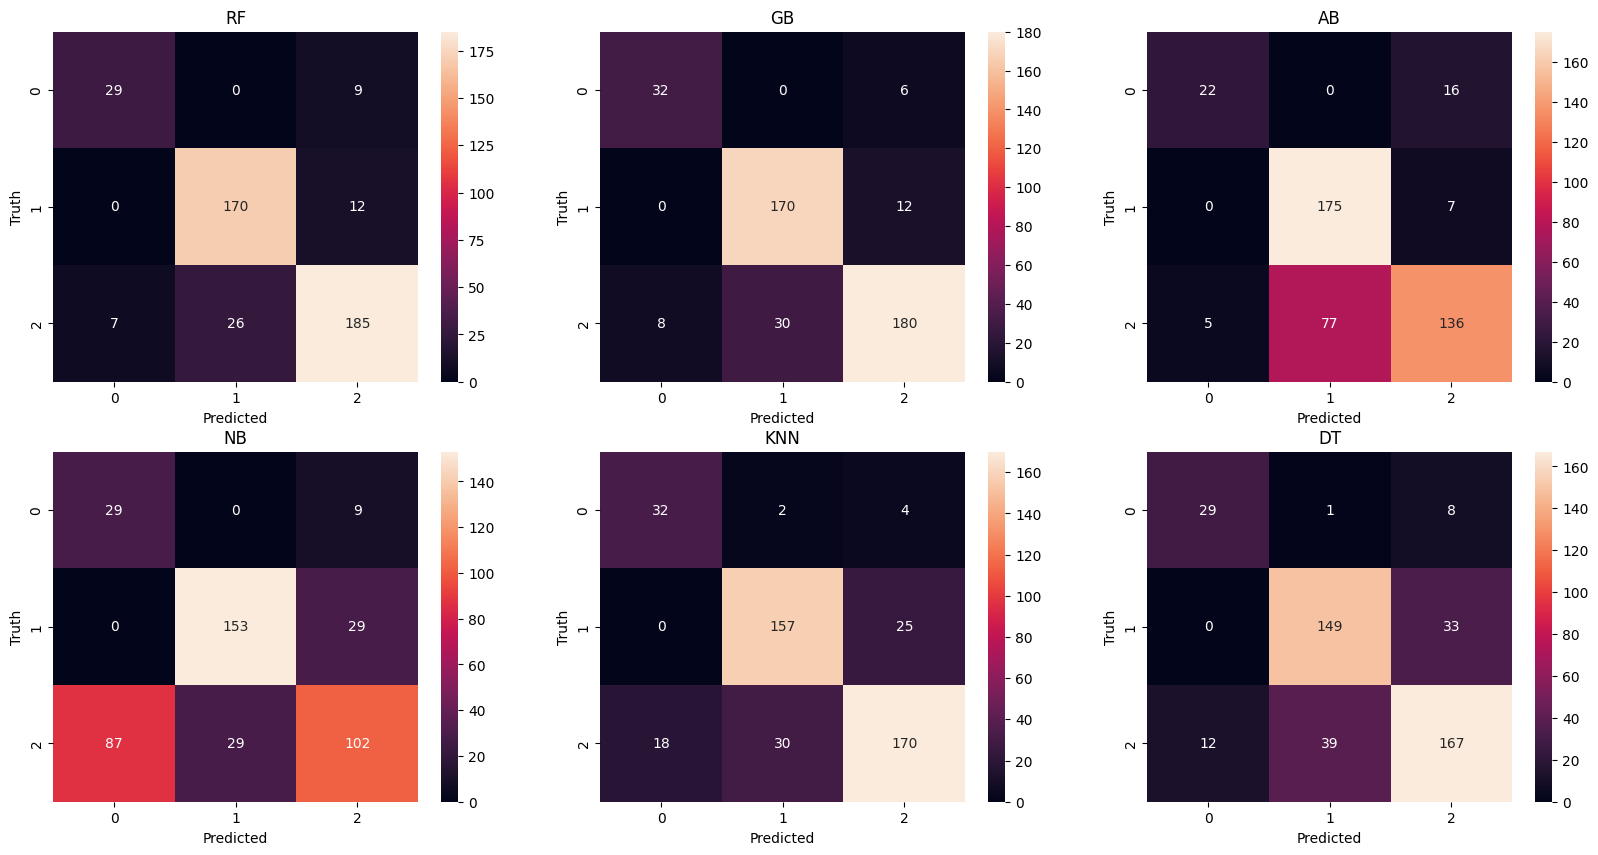

In [434]:
#create a confusion matrix for each model in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (name, model) in enumerate(models):
    row = i // 3
    col = i % 3
    axes[row, col].set_title(name)
    sb.heatmap(results[i][4], annot=True, fmt='d', cmap='rocket', ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Truth')
plt.show()


K-Fold val

In [435]:
from sklearn.model_selection import KFold, cross_val_score


kfold_results = pd.DataFrame()

for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train_smote, y_train_smote, cv=kfold, scoring='accuracy')
    kfold_results[name] = cv_results

In [436]:
kfold_results

,RF,GB,AB,NB,KNN,DT
0,0.918033,0.931148,0.763934,0.760656,0.829508,0.875410
1,0.940984,0.931148,0.806557,0.790164,0.845902,0.872131
2,0.908197,0.914754,0.839344,0.770492,0.832787,0.832787
3,0.895082,0.898361,0.849180,0.767213,0.845902,0.849180
4,0.911184,0.911184,0.825658,0.726974,0.861842,0.875000


## Hyper Parameter Tuning

### Tuning of RandomForest

Random Forest -- Random Search CV


In [437]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_classfier_random = RandomForestClassifier(random_state=seed)

random_search = RandomizedSearchCV(estimator=rf_classfier_random, param_distributions=param_grid_rf, cv=5, scoring='accuracy')

random_search.fit(x_train_smote, y_train_smote)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred = best_model.predict(x_test)
rf_random_accuracy = accuracy_score(y_test, y_pred)


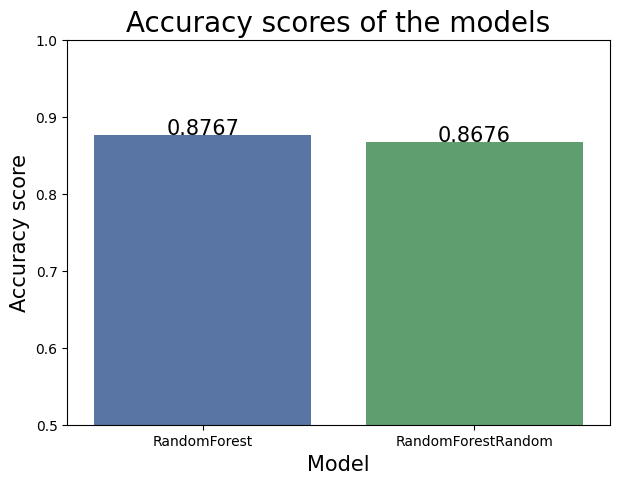

In [438]:

# Define the model names
model_names = ['RandomForest', 'RandomForestRandom']

# Define the accuracy scores
accuracy_scores = [df_results['accuracy'].loc['RF'], rf_random_accuracy]

# Create the bar plot using seaborn
plt.figure(figsize=(7, 5))
sb.barplot(x=model_names, y=accuracy_scores)

# add the the value on the top of each bar
for i in range(len(accuracy_scores)):
    plt.text(i, accuracy_scores[i], round(
        accuracy_scores[i], 4), ha='center', fontsize=15)

# Add labels and title
plt.title("Accuracy scores of the models", fontsize=20)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Accuracy score", fontsize=15)
plt.ylim(0.5, 1)

# Show the plot
plt.show()


### Gradient Boost Hypertuning

Grid Search CV

Random Search CV

In [439]:
if 1 ==0 :
    param_grid_gb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, 20, ],
        'min_samples_split': [2, 5, 10, 15]
    }

    gb_classifier_random = GradientBoostingClassifier(random_state=seed)
    random_search = RandomizedSearchCV(estimator=gb_classifier_random, param_distributions=param_grid_gb, cv=5)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

    random_search.fit(x_train, y_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    y_pred = best_model.predict(x_test)

    gbrandom_accuracy = accuracy_score(y_test, y_pred)

Gradient Boost Hypertuning Comparison

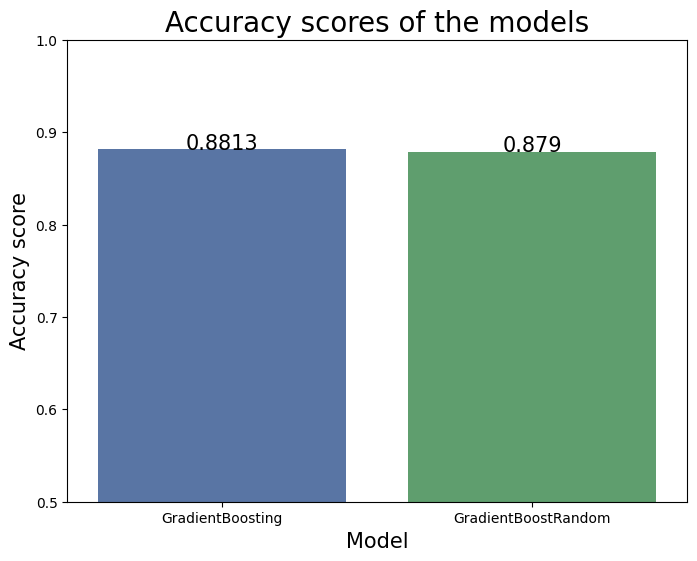

In [440]:

# Define the model names
model_names = ['GradientBoosting', 'GradientBoostRandom']

# Define the accuracy scores
accuracy_scores = [gb_accuracy, gbrandom_accuracy]

# Create the bar plot using seaborn
plt.figure(figsize=(8,6))
sb.barplot(x=model_names, y=accuracy_scores)

# Add the the value on the top of each bar
for i in range(len(accuracy_scores)):
    plt.text(i, accuracy_scores[i], round(accuracy_scores[i], 4), ha = 'center', fontsize = 15)

# Add labels and title
plt.title("Accuracy scores of the models", fontsize=20)

plt.xlabel("Model", fontsize=15)
plt.ylabel("Accuracy score", fontsize=15)
plt.ylim(0.5, 1)

# Show the plot
plt.show()


## Plotting importances

<Axes: ylabel='importance'>

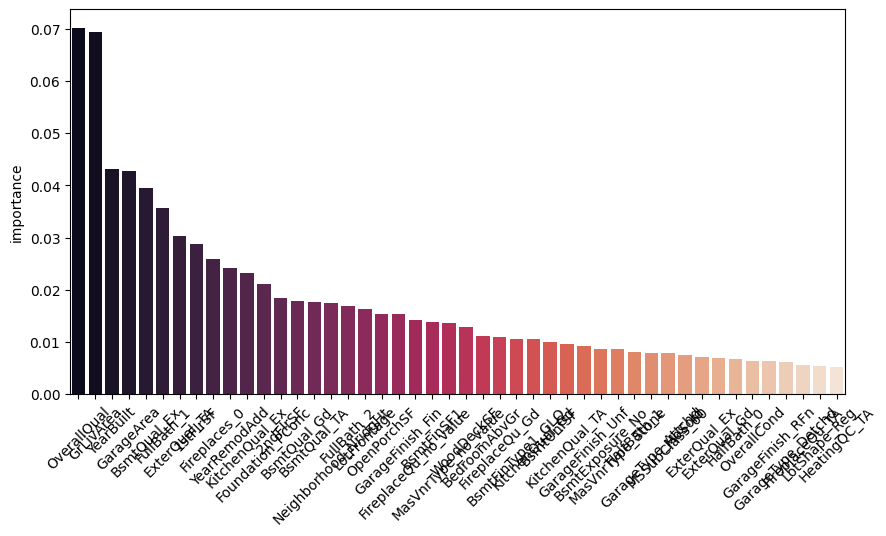

In [441]:
importances = models[0][1].feature_importances_
importances = pd.DataFrame(importances, index = df.drop(['SalePrice'], axis=1).columns, columns=['importance']).sort_values('importance', ascending=False)

importances = importances[importances['importance'] > 0.005]
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sb.barplot(x=importances.index, y=importances['importance'], palette="rocket")

## All models with new features

In [442]:
from sklearn.model_selection import KFold


df2 = df[importances.index]


x2 = np.array(df2.values)
y2 = np.array(df['SalePrice'].values)

x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=test_size, random_state=seed)


In [443]:
smote = BorderlineSMOTE(random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [444]:
results = []
names = []
kfold_results = pd.DataFrame()

for name, model in models:
    model.fit(x_train_smote, y_train_smote)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1score = f1_score(y_test, y_pred, average='weighted')
    results.append([accuracy, precision, recall, f1score, confusion_matrix(y_test, y_pred)])
    names.append(name)
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train_smote, y_train_smote, cv=kfold, scoring='accuracy')
    kfold_results[name] = cv_results

In [445]:
results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Confusion Matrix'], index=names)
results

,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
RF,0.885845,0.886476,0.885845,0.885351,"[[30, 0, 8], [0, 170, 12], [5, 25, 188]]"
GB,0.881279,0.882420,0.881279,0.881045,"[[32, 0, 6], [0, 168, 14], [5, 27, 186]]"
AB,0.776256,0.792160,0.776256,0.769184,"[[19, 0, 19], [0, 174, 8], [4, 67, 147]]"
NB,0.746575,0.795753,0.746575,0.745162,"[[32, 0, 6], [0, 171, 11], [44, 50, 124]]"
KNN,0.819635,0.825882,0.819635,0.820593,"[[32, 2, 4], [0, 157, 25], [18, 30, 170]]"
DT,0.787671,0.789178,0.787671,0.787216,"[[28, 0, 10], [0, 154, 28], [12, 43, 163]]"


In [446]:
kfold_results

,RF,GB,AB,NB,KNN,DT
0,0.914754,0.937705,0.819672,0.819672,0.829508,0.832787
1,0.944262,0.944262,0.852459,0.809836,0.845902,0.839344
2,0.888525,0.901639,0.796721,0.800000,0.832787,0.832787
3,0.908197,0.895082,0.852459,0.780328,0.845902,0.852459
4,0.894737,0.888158,0.815789,0.825658,0.861842,0.871711


### Al confusion matrixes

### Something to do

* SVC 
* Cross Validation
* Logit Regres
* MLP


# Model Evaluation

Evaluating the model without features selection

In [447]:
#split data into train and test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)


#oversample the train data using SMOTE
smote = BorderlineSMOTE(random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)


### ROC

In [448]:
from sklearn.metrics import roc_curve, auc#OVR means One class against the rest

In [449]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['SalePrice']))

In [453]:
probs = []

for name, model in models:
    model.fit(x_train_smote, y_train_smote)
    probs.append(model.predict_proba(x_test))


In [451]:

plt.style.use('seaborn-v0_8-deep')

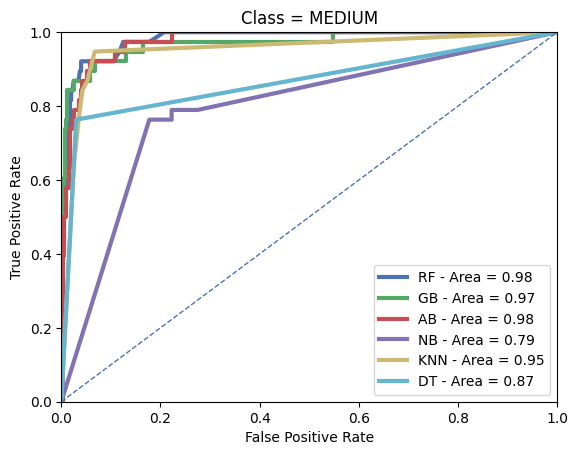

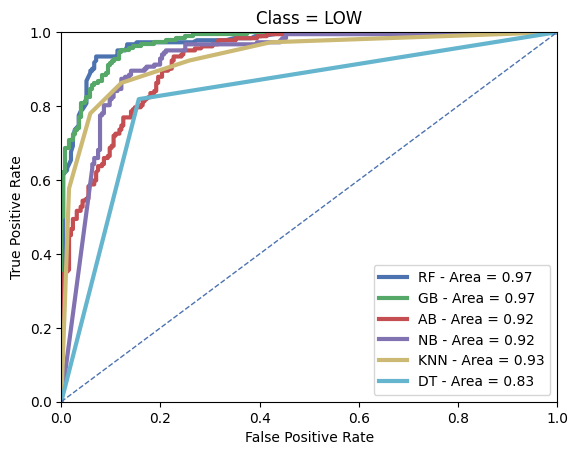

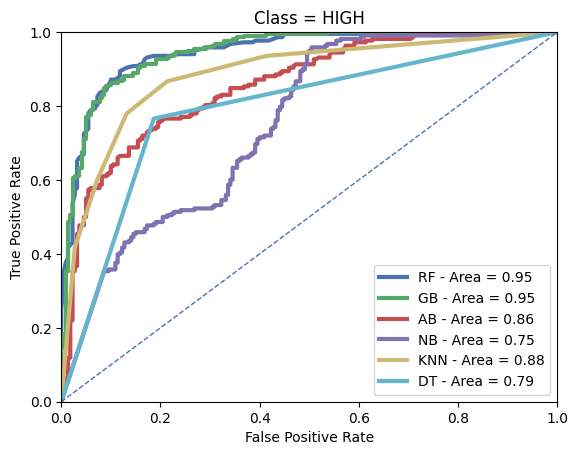

In [452]:
falsepositiverate = dict()
truepositiverate = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0
    for name, _ in models:
        falsepositiverate[i], truepositiverate[i], _ = roc_curve(one_hot_encoding[:,i], probs[m][:,i])

        roc_auc[i] = auc(falsepositiverate[i], truepositiverate[i])
        
        plt.plot(falsepositiverate[i], truepositiverate[i], lw=3, label=f"{name} - Area = {roc_auc[i]:.2f}")
        m += 1
    
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
    plt.title(f'Class = {str(np.unique(y)[2-i])}')
    plt.legend(loc='lower right')

    plt.show()
